In [1]:
import os
import math
import glob
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet50_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

2025-05-20 15:04:48.792774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747753489.026734      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747753489.092119      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
SIZE = 224
BATCH_SIZE = 64 # Điều chỉnh nếu cần dựa trên bộ nhớ
EPOCHS = 20 # Số epochs huấn luyện CNN

In [6]:
base_data_dir = "/kaggle/input/cic-apk/dataset"
train_dir = os.path.join(base_data_dir, "train")
val_dir = os.path.join(base_data_dir, "val")

In [7]:
working_dir = "/kaggle/working/"


In [8]:
def getVGG16Model():
    vgg_model = VGG16(weights='imagenet', input_shape=(SIZE, SIZE, 3), include_top=False)
    for layer in vgg_model.layers[:]:
        layer.trainable = False # Đóng băng các lớp của VGG16

    output = Conv2D(1024, (3,3), padding='same',activation= 'relu')(vgg_model.output)
    output = Conv2D(1024, (3,3), padding='same',activation= 'relu')(output)
    output = Conv2D(1024, (3,3), padding='same',activation= 'relu')(output)
    output = MaxPooling2D(pool_size=(2,2),strides = (2,2))(output)
    output = GlobalAveragePooling2D(name='vgg_base_pooling')(output)
    vgg_model = Model(vgg_model.input, output, name='VGG16_BaseCustom')
    return vgg_model

In [9]:
def getResNet50Model():
    resnet_model = ResNet50(weights='imagenet', input_shape=(SIZE, SIZE, 3), include_top=False)
    for layer in resnet_model.layers[:]:
        layer.trainable = False # Đóng băng các lớp của ResNet50

    output = Conv2D(1024, (3,3), padding='same',activation= 'relu')(resnet_model.output)
    output = GlobalAveragePooling2D(name='resnet_base_pooling')(output)
    resnet_model = Model(resnet_model.input, output, name='ResNet50_BaseCustom')
    return resnet_model

In [10]:

datagen_resnet = ImageDataGenerator(preprocessing_function=resnet50_preprocess_input)
datagen_vgg = ImageDataGenerator(preprocessing_function=vgg16_preprocess_input)

In [11]:
# --- Tạo Generators cho Training và Validation (ResNet) ---

train_generator_resnet = datagen_resnet.flow_from_directory(
    train_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True # Luôn shuffle tập train
)

val_generator_resnet = datagen_resnet.flow_from_directory(
    val_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Không shuffle tập validation/test
)

# --- Tạo Generators cho Training và Validation (VGG) ---
# Sử dụng cùng cấu trúc thư mục, chỉ khác hàm tiền xử lý

train_generator_vgg = datagen_vgg.flow_from_directory(
    train_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator_vgg = datagen_vgg.flow_from_directory(
    val_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 12429 images belonging to 5 classes.
Found 3111 images belonging to 5 classes.
Found 12429 images belonging to 5 classes.
Found 3111 images belonging to 5 classes.


In [12]:
num_train_samples = train_generator_resnet.samples
num_val_samples = val_generator_resnet.samples
num_classes = train_generator_resnet.num_classes
class_indices = train_generator_resnet.class_indices
labels = list(class_indices.keys()) # ['Benign', 'Adware','Banking','Riskware','SMS']

In [13]:
print(f"\nTìm thấy {num_train_samples} ảnh huấn luyện thuộc {num_classes} lớp.")
print(f"Tìm thấy {num_val_samples} ảnh validation thuộc {num_classes} lớp.")
print(f"Các lớp: {class_indices}")
print(f"Tên lớp: {labels}")



Tìm thấy 12429 ảnh huấn luyện thuộc 5 lớp.
Tìm thấy 3111 ảnh validation thuộc 5 lớp.
Các lớp: {'Adware': 0, 'Banking': 1, 'Benign': 2, 'Riskware': 3, 'SMS': 4}
Tên lớp: ['Adware', 'Banking', 'Benign', 'Riskware', 'SMS']


In [14]:
# Tính toán steps
steps_per_epoch = math.ceil(num_train_samples / BATCH_SIZE)
validation_steps = math.ceil(num_val_samples / BATCH_SIZE)

# Lấy nhãn đúng cho tập validation/test (dạng số 0, 1,...)
y_test_true = val_generator_resnet.classes

# Lấy nhãn đúng cho tập train (cần tạo generator không shuffle)
temp_train_gen_for_labels = datagen_resnet.flow_from_directory( # Dùng datagen nào cũng được vì chỉ lấy label
    train_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE, # Batch size không quá quan trọng ở đây
    class_mode='categorical',
    shuffle=False # QUAN TRỌNG
)
y_train_true = temp_train_gen_for_labels.classes
# Giải phóng bộ nhớ của generator tạm
del temp_train_gen_for_labels

# Khởi tạo LabelEncoder để chuyển đổi giữa số và tên lớp
le_final = LabelEncoder()
le_final.fit(labels)


Found 12429 images belonging to 5 classes.


LabelEncoder()

In [15]:
resnet_base = getResNet50Model()
x = resnet_base.output
# Đặt tên cho các lớp Dense để dễ dàng trích xuất
x = Dense(2048, activation='relu', name='resnet_dense_1')(x)
x = Dense(1024, activation='relu', name='resnet_dense_2')(x) # Layer muốn trích xuất
output = Dense(num_classes, activation='softmax', name='output_resnet')(x)
resnet_final_model = Model(inputs=resnet_base.input, outputs=output)

I0000 00:00:1747753512.381299      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747753512.382026      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
resnet_final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet_final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 46,665,605 (178.02 MB)

 Trainable params: 23,077,893 (88.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
# --- Huấn luyện ResNet ---
checkpoint_filepath_resnet = os.path.join(working_dir, 'resnet_model_best.keras')
model_checkpoint_callback_resnet = ModelCheckpoint(
    filepath=checkpoint_filepath_resnet,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
history_resnet = resnet_final_model.fit(
    train_generator_resnet,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator_resnet,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint_callback_resnet]
)


Epoch 1/20


I0000 00:00:1747753527.610191     132 service.cc:148] XLA service 0x79737c002dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747753527.611373     132 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747753527.611394     132 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747753529.176160     132 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-20 15:05:36.322799: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[64,1024,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,7,7]{3,2,1,0}, f32[1024,2048,3,3]{3,2,1,0}, f32[1024]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedul

  1/195 ━━━━━━━━━━━━━━━━━━━━ 1:17:41 24s/step - accuracy: 0.1875 - loss: 1.8480

I0000 00:00:1747753540.468871     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.6980 - loss: 2.1262
Epoch 1: val_accuracy improved from -inf to 0.86275, saving model to /kaggle/working/resnet_model_best.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 139s 595ms/step - accuracy: 0.6985 - loss: 2.1199 - val_accuracy: 0.8627 - val_loss: 0.4142
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8822 - loss: 0.3538
Epoch 2: val_accuracy improved from 0.86275 to 0.89778, saving model to /kaggle/working/resnet_model_best.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 66s 335ms/step - accuracy: 0.8822 - loss: 0.3537 - val_accuracy: 0.8978 - val_loss: 0.3496
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9119 - loss: 0.2741
Epoch 3: val_accuracy improved from 0.89778 to 0.90325, saving model to /kaggle/working/resnet_model_best.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - accuracy: 0.9119 - loss: 0.2741 - val_accuracy: 0.9032 - val_loss: 0.2973
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step

In [18]:
# --- Trích xuất Đặc trưng ResNet ---
# Load mô hình tốt nhất
resnet_best_model = load_model(checkpoint_filepath_resnet)

# Tạo model trích xuất
feature_extractor_layer_name_resnet = 'resnet_dense_2' 
try:
    features_extractor_resnet = Model(inputs=resnet_best_model.input,
                                      outputs=resnet_best_model.get_layer(feature_extractor_layer_name_resnet).output)
except ValueError as e:
    print(f"LỖI: Không tìm thấy layer '{feature_extractor_layer_name_resnet}'. Kiểm tra lại summary().")
    raise e

# Tạo generator cho dự đoán (không shuffle, không nhãn)
predict_gen_train_resnet = datagen_resnet.flow_from_directory(
    train_dir, target_size=(SIZE, SIZE), batch_size=BATCH_SIZE, class_mode=None, shuffle=False)
predict_gen_val_resnet = datagen_resnet.flow_from_directory(
    val_dir, target_size=(SIZE, SIZE), batch_size=BATCH_SIZE, class_mode=None, shuffle=False)

# Tính số bước predict
predict_steps_train = math.ceil(predict_gen_train_resnet.samples / BATCH_SIZE)
predict_steps_val = math.ceil(predict_gen_val_resnet.samples / BATCH_SIZE)

# Trích xuất
X_train_Resnet = features_extractor_resnet.predict(predict_gen_train_resnet, steps=predict_steps_train, verbose=1)
X_test_Resnet = features_extractor_resnet.predict(predict_gen_val_resnet, steps=predict_steps_val, verbose=1)

# Lưu đặc trưng
np.save(os.path.join(working_dir, 'X_train_Resnet.npy'), X_train_Resnet)
np.save(os.path.join(working_dir, 'X_test_Resnet.npy'), X_test_Resnet)
print(f"Đã lưu đặc trưng ResNet Train: {X_train_Resnet.shape}")
print(f"Đã lưu đặc trưng ResNet Test/Val: {X_test_Resnet.shape}")

Found 12429 images belonging to 5 classes.
Found 3111 images belonging to 5 classes.
195/195 ━━━━━━━━━━━━━━━━━━━━ 57s 271ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step
Đã lưu đặc trưng ResNet Train: (12429, 1024)
Đã lưu đặc trưng ResNet Test/Val: (3111, 1024)


In [19]:
# --- Xây dựng Mô hình VGG cuối cùng ---
vgg_base = getVGG16Model()
x = vgg_base.output
x = Dense(2048, activation='relu', name='vgg_dense_1')(x)
x = Dense(1024, activation='relu', name='vgg_dense_2')(x) # Layer muốn trích xuất
output = Dense(num_classes, activation='softmax', name='output_vgg')(x)
vgg_final_model = Model(inputs=vgg_base.input, outputs=output)

vgg_final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg_final_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 1024)          │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 42,513,221 (162.18 MB)

 Trainable params: 27,798,533 (106.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:

# --- Huấn luyện VGG ---
checkpoint_filepath_vgg = os.path.join(working_dir, 'vgg_model_best.keras')
model_checkpoint_callback_vgg = ModelCheckpoint(
    filepath=checkpoint_filepath_vgg,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_vgg = vgg_final_model.fit(
    train_generator_vgg, # Sử dụng generator VGG
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator_vgg, # Sử dụng generator VGG
    validation_steps=validation_steps,
    callbacks=[model_checkpoint_callback_vgg]
)


Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6007 - loss: 7.1451
Epoch 1: val_accuracy improved from -inf to 0.84796, saving model to /kaggle/working/vgg_model_best.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 169s 686ms/step - accuracy: 0.6014 - loss: 7.1184 - val_accuracy: 0.8480 - val_loss: 0.4640
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8806 - loss: 0.3563
Epoch 2: val_accuracy improved from 0.84796 to 0.88460, saving model to /kaggle/working/vgg_model_best.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 103s 527ms/step - accuracy: 0.8806 - loss: 0.3562 - val_accuracy: 0.8846 - val_loss: 0.3504
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9061 - loss: 0.2874
Epoch 3: val_accuracy did not improve from 0.88460
195/195 ━━━━━━━━━━━━━━━━━━━━ 101s 519ms/step - accuracy: 0.9061 - loss: 0.2874 - val_accuracy: 0.8801 - val_loss: 0.3819
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9207 - loss: 0.2520
Epoch 4: val_accura

In [21]:
# --- Trích xuất Đặc trưng VGG ---
# Load mô hình tốt nhất
vgg_best_model = load_model(checkpoint_filepath_vgg)

# Tạo model trích xuất
feature_extractor_layer_name_vgg = 'vgg_dense_2' 
try:
    features_extractor_vgg = Model(inputs=vgg_best_model.input,
                                   outputs=vgg_best_model.get_layer(feature_extractor_layer_name_vgg).output)
except ValueError as e:
    print(f"LỖI: Không tìm thấy layer '{feature_extractor_layer_name_vgg}'. Kiểm tra lại summary().")
    raise e

# Tạo generator cho dự đoán (không shuffle, không nhãn)
predict_gen_train_vgg = datagen_vgg.flow_from_directory(
    train_dir, target_size=(SIZE, SIZE), batch_size=BATCH_SIZE, class_mode=None, shuffle=False)
predict_gen_val_vgg = datagen_vgg.flow_from_directory(
    val_dir, target_size=(SIZE, SIZE), batch_size=BATCH_SIZE, class_mode=None, shuffle=False)

# Số bước predict (giống như ResNet vì số lượng ảnh như nhau)
# predict_steps_train = math.ceil(predict_gen_train_vgg.samples / BATCH_SIZE)
# predict_steps_val = math.ceil(predict_gen_val_vgg.samples / BATCH_SIZE)

# Trích xuất
X_train_VGG = features_extractor_vgg.predict(predict_gen_train_vgg, steps=predict_steps_train, verbose=1)
X_test_VGG = features_extractor_vgg.predict(predict_gen_val_vgg, steps=predict_steps_val, verbose=1)

# Lưu đặc trưng
np.save(os.path.join(working_dir, 'X_train_VGG.npy'), X_train_VGG)
np.save(os.path.join(working_dir, 'X_test_VGG.npy'), X_test_VGG)
print(f"Đã lưu đặc trưng VGG Train: {X_train_VGG.shape}")
print(f"Đã lưu đặc trưng VGG Test/Val: {X_test_VGG.shape}")


Found 12429 images belonging to 5 classes.
Found 3111 images belonging to 5 classes.
195/195 ━━━━━━━━━━━━━━━━━━━━ 75s 379ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step
Đã lưu đặc trưng VGG Train: (12429, 1024)
Đã lưu đặc trưng VGG Test/Val: (3111, 1024)


In [22]:
# Load lại (nếu cần)
# X_train_VGG = np.load(os.path.join(working_dir, 'X_train_VGG.npy'))
# X_test_VGG = np.load(os.path.join(working_dir, 'X_test_VGG.npy'))
# X_train_Resnet = np.load(os.path.join(working_dir, 'X_train_Resnet.npy'))
# X_test_Resnet = np.load(os.path.join(working_dir, 'X_test_Resnet.npy'))

# Concatenate
X_train_hybrid = np.concatenate((X_train_VGG, X_train_Resnet), axis=1)
X_test_hybrid = np.concatenate((X_test_VGG, X_test_Resnet), axis=1)

np.save(os.path.join(working_dir, 'X_train_hybrid.npy'), X_train_hybrid)
np.save(os.path.join(working_dir, 'X_test_hybrid.npy'), X_test_hybrid)

print(f"Shape đặc trưng kết hợp (Train): {X_train_hybrid.shape}")
print(f"Shape đặc trưng kết hợp (Test/Val): {X_test_hybrid.shape}")

Shape đặc trưng kết hợp (Train): (12429, 2048)
Shape đặc trưng kết hợp (Test/Val): (3111, 2048)


In [23]:
X_train_final_unscaled = X_train_hybrid
X_test_final_unscaled = X_test_hybrid
y_train_final = y_train_true # Nhãn đã lấy ở bước tạo generator
y_test_final = y_test_true   # Nhãn đã lấy ở bước tạo generator

print("\nChuẩn hóa đặc trưng kết hợp bằng StandardScaler...")
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final_unscaled)
X_test_final = scaler.transform(X_test_final_unscaled) # Chỉ transform tập test

print("Shape dữ liệu cuối cùng:")
print("Train features:", X_train_final.shape)
print("Test features:", X_test_final.shape)
print("Train labels:", y_train_final.shape)
print("Test labels:", y_test_final.shape)


Chuẩn hóa đặc trưng kết hợp bằng StandardScaler...
Shape dữ liệu cuối cùng:
Train features: (12429, 2048)
Test features: (3111, 2048)
Train labels: (12429,)
Test labels: (3111,)


In [24]:
# --- Hàm vẽ Confusion Matrix ---
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', figsize=(8, 6), fontsize=14):
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

# RandomForestClassifier

In [25]:
# Tầng 1: Huấn luyện trên đặc trưng gốc, dự đoán xác suất
clf1_rf = RandomForestClassifier(n_estimators=300, max_depth=300, random_state=42, n_jobs=-1)
clf1_rf.fit(X_train_final, y_train_final)
prob_train_rf = clf1_rf.predict_proba(X_train_final)
prob_test_rf = clf1_rf.predict_proba(X_test_final)

# Tầng 2: Huấn luyện trên xác suất từ tầng 1
clf2_rf = RandomForestClassifier(n_estimators=300, max_depth=300, random_state=42, n_jobs=-1)
clf2_rf.fit(prob_train_rf, y_train_final)
y_pred_rf = clf2_rf.predict(prob_test_rf)

RF (Bi-Model) Accuracy: 0.9341
RF (Bi-Model) F1 Score: 0.9206
RF (Bi-Model) Precision: 0.9189
RF (Bi-Model) Recall: 0.9228

RF (Bi-Model) Classification Report:
              precision    recall  f1-score   support

      Adware       0.88      0.90      0.89       303
     Banking       0.86      0.91      0.88       494
      Benign       0.96      0.94      0.95       808
    Riskware       0.91      0.89      0.90       543
         SMS       0.98      0.98      0.98       963

    accuracy                           0.93      3111
   macro avg       0.92      0.92      0.92      3111
weighted avg       0.94      0.93      0.93      3111



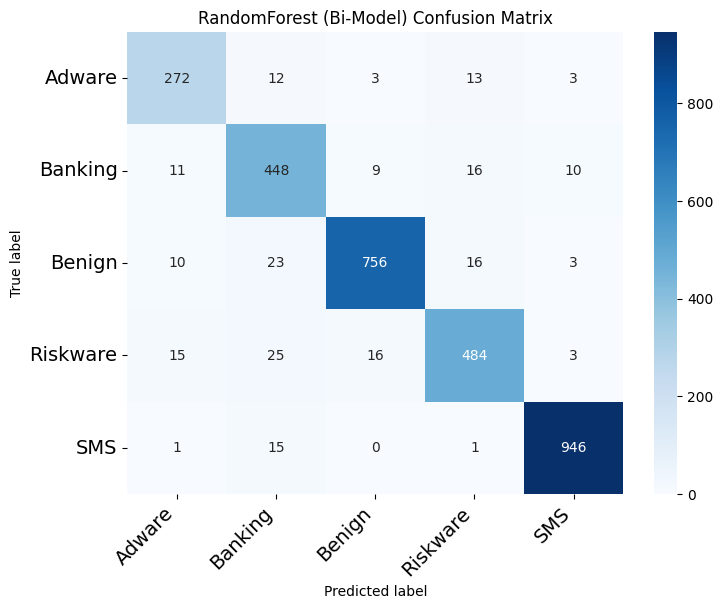

In [26]:
# Đánh giá
accuracy_rf = accuracy_score(y_test_final, y_pred_rf)
f1_rf = f1_score(y_test_final, y_pred_rf, average='macro')
precision_rf = precision_score(y_test_final, y_pred_rf, average='macro')
recall_rf = recall_score(y_test_final, y_pred_rf, average='macro')

print(f"RF (Bi-Model) Accuracy: {accuracy_rf:.4f}")
print(f"RF (Bi-Model) F1 Score: {f1_rf:.4f}")
print(f"RF (Bi-Model) Precision: {precision_rf:.4f}")
print(f"RF (Bi-Model) Recall: {recall_rf:.4f}")
print("\nRF (Bi-Model) Classification Report:")
print(classification_report(y_test_final, y_pred_rf, target_names=labels))
cm_rf = sk_confusion_matrix(y_test_final, y_pred_rf)
plot_confusion_matrix(cm_rf, class_names=labels, title='RandomForest (Bi-Model) Confusion Matrix')


#  SVC (Bi-Model)

In [27]:
# Tầng 1
svm1 = SVC(kernel='poly', C=2.0, probability=True, random_state=42) # probability=True là cần thiết
svm1.fit(X_train_final, y_train_final)
prob_train_svm = svm1.predict_proba(X_train_final)
prob_test_svm = svm1.predict_proba(X_test_final)

# Tầng 2
svm2 = SVC(kernel='poly', C=2.0, probability=False, random_state=42) # Tầng 2 không cần probability
svm2.fit(prob_train_svm, y_train_final)
y_pred_svm = svm2.predict(prob_test_svm)

SVC (Bi-Model) Accuracy: 0.9357
SVC (Bi-Model) F1 Score: 0.9220
SVC (Bi-Model) Precision: 0.9216
SVC (Bi-Model) Recall: 0.9228

SVC (Bi-Model) Classification Report:
              precision    recall  f1-score   support

      Adware       0.89      0.89      0.89       303
     Banking       0.87      0.91      0.89       494
      Benign       0.95      0.95      0.95       808
    Riskware       0.91      0.88      0.90       543
         SMS       0.98      0.98      0.98       963

    accuracy                           0.94      3111
   macro avg       0.92      0.92      0.92      3111
weighted avg       0.94      0.94      0.94      3111



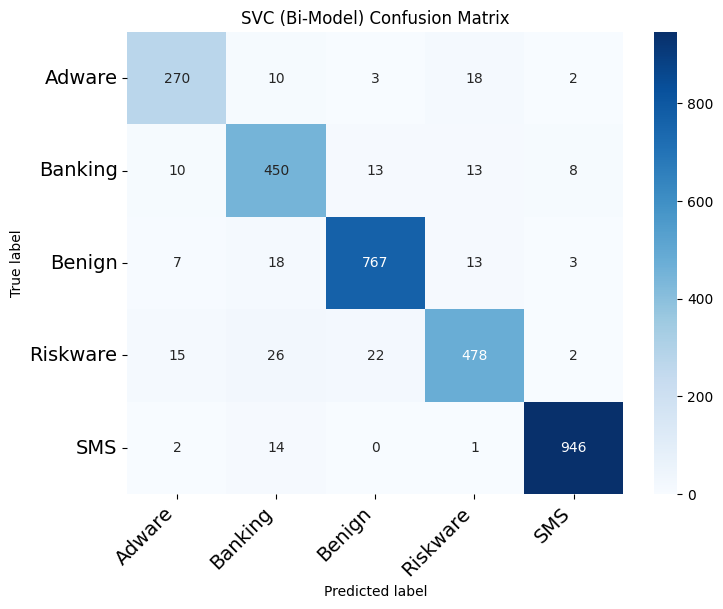

In [28]:
# Đánh giá
accuracy_svm = accuracy_score(y_test_final, y_pred_svm)
f1_svm = f1_score(y_test_final, y_pred_svm, average='macro')
precision_svm = precision_score(y_test_final, y_pred_svm, average='macro')
recall_svm = recall_score(y_test_final, y_pred_svm, average='macro')

print(f"SVC (Bi-Model) Accuracy: {accuracy_svm:.4f}")
print(f"SVC (Bi-Model) F1 Score: {f1_svm:.4f}")
print(f"SVC (Bi-Model) Precision: {precision_svm:.4f}")
print(f"SVC (Bi-Model) Recall: {recall_svm:.4f}")
print("\nSVC (Bi-Model) Classification Report:")
print(classification_report(y_test_final, y_pred_svm, target_names=labels))
cm_svm = sk_confusion_matrix(y_test_final, y_pred_svm)
plot_confusion_matrix(cm_svm, class_names=labels, title='SVC (Bi-Model) Confusion Matrix')


# KNeighborsClassifier (Bi-Model)

In [29]:
# Tầng 1
knn1 = KNeighborsClassifier(n_neighbors=5)
knn1.fit(X_train_final, y_train_final)
prob_train_knn = knn1.predict_proba(X_train_final)
prob_test_knn = knn1.predict_proba(X_test_final)

# Tầng 2
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(prob_train_knn, y_train_final)
y_pred_knn = knn2.predict(prob_test_knn)

KNN (Bi-Model) Accuracy: 0.9264
KNN (Bi-Model) F1 Score: 0.9124
KNN (Bi-Model) Precision: 0.9110
KNN (Bi-Model) Recall: 0.9161

KNN (Bi-Model) Classification Report:
              precision    recall  f1-score   support

      Adware       0.88      0.90      0.89       303
     Banking       0.81      0.93      0.86       494
      Benign       0.96      0.94      0.95       808
    Riskware       0.92      0.85      0.88       543
         SMS       0.99      0.97      0.98       963

    accuracy                           0.93      3111
   macro avg       0.91      0.92      0.91      3111
weighted avg       0.93      0.93      0.93      3111



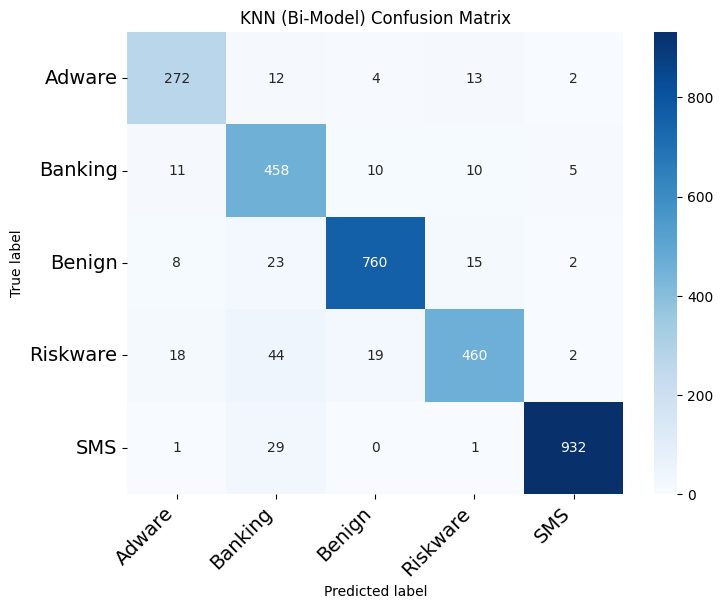

In [30]:
# Đánh giá
accuracy_knn = accuracy_score(y_test_final, y_pred_knn)
f1_knn = f1_score(y_test_final, y_pred_knn, average='macro')
precision_knn = precision_score(y_test_final, y_pred_knn, average='macro')
recall_knn = recall_score(y_test_final, y_pred_knn, average='macro')

print(f"KNN (Bi-Model) Accuracy: {accuracy_knn:.4f}")
print(f"KNN (Bi-Model) F1 Score: {f1_knn:.4f}")
print(f"KNN (Bi-Model) Precision: {precision_knn:.4f}")
print(f"KNN (Bi-Model) Recall: {recall_knn:.4f}")
print("\nKNN (Bi-Model) Classification Report:")
print(classification_report(y_test_final, y_pred_knn, target_names=labels))
cm_knn = sk_confusion_matrix(y_test_final, y_pred_knn)
plot_confusion_matrix(cm_knn, class_names=labels, title='KNN (Bi-Model) Confusion Matrix')


# LogisticRegression (Bi-Model)

In [31]:
# Tầng 1
lr1 = LogisticRegression(solver='liblinear', C=3.0, random_state=42, max_iter=200)
lr1.fit(X_train_final, y_train_final)
prob_train_lr = lr1.predict_proba(X_train_final)
prob_test_lr = lr1.predict_proba(X_test_final)

# Tầng 2
lr2 = LogisticRegression(solver='liblinear', C=3.0, random_state=42, max_iter=200)
lr2.fit(prob_train_lr, y_train_final)
y_pred_lr = lr2.predict(prob_test_lr)

LR (Bi-Model) Accuracy: 0.9319
LR (Bi-Model) F1 Score: 0.9191
LR (Bi-Model) Precision: 0.9196
LR (Bi-Model) Recall: 0.9187

LR (Bi-Model) Classification Report:
              precision    recall  f1-score   support

      Adware       0.90      0.88      0.89       303
     Banking       0.88      0.90      0.89       494
      Benign       0.95      0.94      0.94       808
    Riskware       0.90      0.88      0.89       543
         SMS       0.98      0.98      0.98       963

    accuracy                           0.93      3111
   macro avg       0.92      0.92      0.92      3111
weighted avg       0.93      0.93      0.93      3111



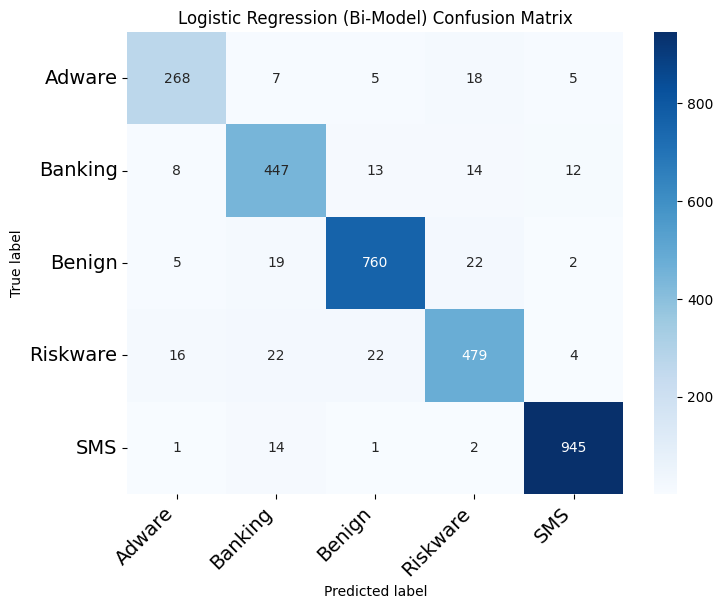

In [32]:
# Đánh giá
accuracy_lr = accuracy_score(y_test_final, y_pred_lr)
f1_lr = f1_score(y_test_final, y_pred_lr, average='macro')
precision_lr = precision_score(y_test_final, y_pred_lr, average='macro')
recall_lr = recall_score(y_test_final, y_pred_lr, average='macro')

print(f"LR (Bi-Model) Accuracy: {accuracy_lr:.4f}")
print(f"LR (Bi-Model) F1 Score: {f1_lr:.4f}")
print(f"LR (Bi-Model) Precision: {precision_lr:.4f}")
print(f"LR (Bi-Model) Recall: {recall_lr:.4f}")
print("\nLR (Bi-Model) Classification Report:")
print(classification_report(y_test_final, y_pred_lr, target_names=labels))
cm_lr = sk_confusion_matrix(y_test_final, y_pred_lr)
plot_confusion_matrix(cm_lr, class_names=labels, title='Logistic Regression (Bi-Model) Confusion Matrix')


# Major Voting Ensemble

Huấn luyện Voting Classifier trên xác suất tầng 1...

Voting Ensemble (Manual) Accuracy: 0.9341
Voting Ensemble (Manual) F1 Score: 0.9206
Voting Ensemble (Manual) Precision: 0.9187
Voting Ensemble (Manual) Recall: 0.9231

Voting Ensemble (Manual) Classification Report:
              precision    recall  f1-score   support

      Adware       0.88      0.90      0.89       303
     Banking       0.86      0.92      0.89       494
      Benign       0.96      0.94      0.95       808
    Riskware       0.91      0.88      0.89       543
         SMS       0.99      0.98      0.98       963

    accuracy                           0.93      3111
   macro avg       0.92      0.92      0.92      3111
weighted avg       0.94      0.93      0.93      3111



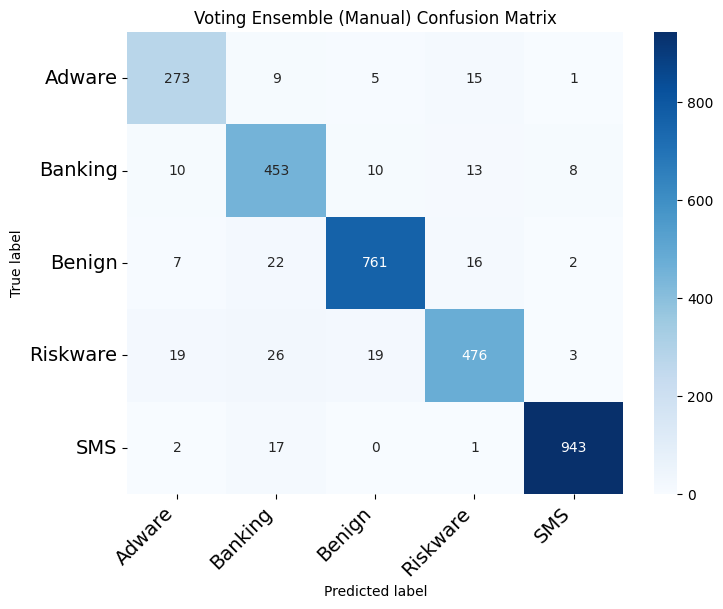

In [33]:
# Sử dụng các mô hình tầng 2 đã được huấn luyện
estimators_final = [
    ('SVM2', svm2), # Sử dụng svm2 đã fit trên prob_train_svm
    ('RF2', clf2_rf), # Sử dụng clf2_rf đã fit trên prob_train_rf
    ('LR2', lr2),   # Sử dụng lr2 đã fit trên prob_train_lr
    ('KNN2', knn2)  # Sử dụng knn2 đã fit trên prob_train_knn
]

# Tạo Voting Classifier
# Lưu ý: Voting trên các mô hình đã được huấn luyện (như thế này) chỉ có ý nghĩa nếu dùng voting='soft'
# và các mô hình tầng 2 này có predict_proba hợp lý trên đầu vào là xác suất.
# Voting 'hard' sẽ dự đoán lại trên dữ liệu test bằng các mô hình tầng 2.
# ensemble_clf_final = VotingClassifier(estimators=estimators_final, voting='hard') # Hoặc 'soft' nếu các model tầng 2 có predict_proba tốt

# Cách tiếp cận khác: Huấn luyện VotingClassifier từ đầu với pipeline 2 tầng, phức tạp hơn.

# Cách đơn giản nhất để tái tạo logic gốc cho voting: Coi như voting trên dự đoán cuối cùng
# Hoặc huấn luyện voting classifier trên output xác suất của tầng 1
print("Huấn luyện Voting Classifier trên xác suất tầng 1...")

# Tạo dữ liệu xác suất kết hợp từ tầng 1
prob_train_all_models = np.concatenate(
    (prob_train_rf, prob_train_svm, prob_train_lr, prob_train_knn), axis=1
)
prob_test_all_models = np.concatenate(
    (prob_test_rf, prob_test_svm, prob_test_lr, prob_test_knn), axis=1
)

# Tạo lại các estimators tầng 2 (CHƯA HUẤN LUYỆN) để dùng trong VotingClassifier nếu muốn CV
estimators_for_voting = [
    ('SVM2', SVC(kernel='poly', C=2.0, probability=False, random_state=42)),
    ('RF2', RandomForestClassifier(n_estimators=300, max_depth=300, random_state=42, n_jobs=-1)),
    ('LR2', LogisticRegression(solver='liblinear', C=3.0, random_state=42, max_iter=200)),
    ('KNN2', KNeighborsClassifier(n_neighbors=5))
]
ensemble_clf_on_prob = VotingClassifier(estimators=estimators_for_voting, voting='soft')

# Huấn luyện VotingClassifier trên prob_train của tất cả mô hình tầng 1 (Cách này không giống code gốc)
# ensemble_clf_on_prob.fit(prob_train_all_models, y_train_final)
# y_pred_ensemble = ensemble_clf_on_prob.predict(prob_test_all_models)

# -> Để giữ gần nhất với logic CV gốc (đánh giá các mô hình tầng 2):
#    Chúng ta sẽ dùng lại các mô hình tầng 2 đã huấn luyện và đánh giá ensemble dựa trên chúng

# Lấy các mô hình tầng 2 đã huấn luyện
final_trained_estimators = {
    'SVM2': svm2,
    'RF2': clf2_rf,
    'LR2': lr2,
    'KNN2': knn2
}

# Định nghĩa lại hàm get_voting dùng các mô hình TẦNG 2 đã fit
def get_voting_final(estimators_dict):
    models = list(estimators_dict.items())
    ensemble = VotingClassifier(estimators=models, voting='soft')
    # Cần fit lại ensemble này nếu muốn dùng predict trực tiếp
    return ensemble

# Ensemble này cần được fit lại trên tập train tương ứng (là prob_train)
# Hoặc chúng ta chỉ dùng để đánh giá CV
# ensemble_final = get_voting_final(final_trained_estimators)
# ensemble_final.fit(prob_train_all_models, y_train_final) # Fit lại ensemble trên prob train
# y_pred_ensemble = ensemble_final.predict(prob_test_all_models) # Predict trên prob test

# --> Cách đơn giản nhất để tính kết quả Voting từ các dự đoán đã có:
predictions = np.array([y_pred_rf, y_pred_svm, y_pred_knn, y_pred_lr])
# Lấy dự đoán đa số (mode) cho từng mẫu
from scipy.stats import mode
y_pred_ensemble_manual, _ = mode(predictions, axis=0, keepdims=False) # Sử dụng keepdims=False nếu phiên bản scipy mới

# Đánh giá ensemble thủ công
accuracy_ensemble = accuracy_score(y_test_final, y_pred_ensemble_manual)
f1_ensemble = f1_score(y_test_final, y_pred_ensemble_manual, average='macro')
precision_ensemble = precision_score(y_test_final, y_pred_ensemble_manual, average='macro')
recall_ensemble = recall_score(y_test_final, y_pred_ensemble_manual, average='macro')

print(f"\nVoting Ensemble (Manual) Accuracy: {accuracy_ensemble:.4f}")
print(f"Voting Ensemble (Manual) F1 Score: {f1_ensemble:.4f}")
print(f"Voting Ensemble (Manual) Precision: {precision_ensemble:.4f}")
print(f"Voting Ensemble (Manual) Recall: {recall_ensemble:.4f}")
print("\nVoting Ensemble (Manual) Classification Report:")
print(classification_report(y_test_final, y_pred_ensemble_manual, target_names=labels))
cm_ensemble = sk_confusion_matrix(y_test_final, y_pred_ensemble_manual)
plot_confusion_matrix(cm_ensemble, class_names=labels, title='Voting Ensemble (Manual) Confusion Matrix')




--- So sánh hiệu năng các mô hình trên Tập Test ---
Bảng tổng hợp kết quả trên tập test:
          Model Accuracy F1 Score (Macro) Precision (Macro) Recall (Macro)
  RF (Bi-Model)   0.9341           0.9206            0.9189         0.9228
 SVC (Bi-Model)   0.9357           0.9220            0.9216         0.9228
 KNN (Bi-Model)   0.9264           0.9124            0.9110         0.9161
  LR (Bi-Model)   0.9319           0.9191            0.9196         0.9187
Voting Ensemble   0.9341           0.9206            0.9187         0.9231


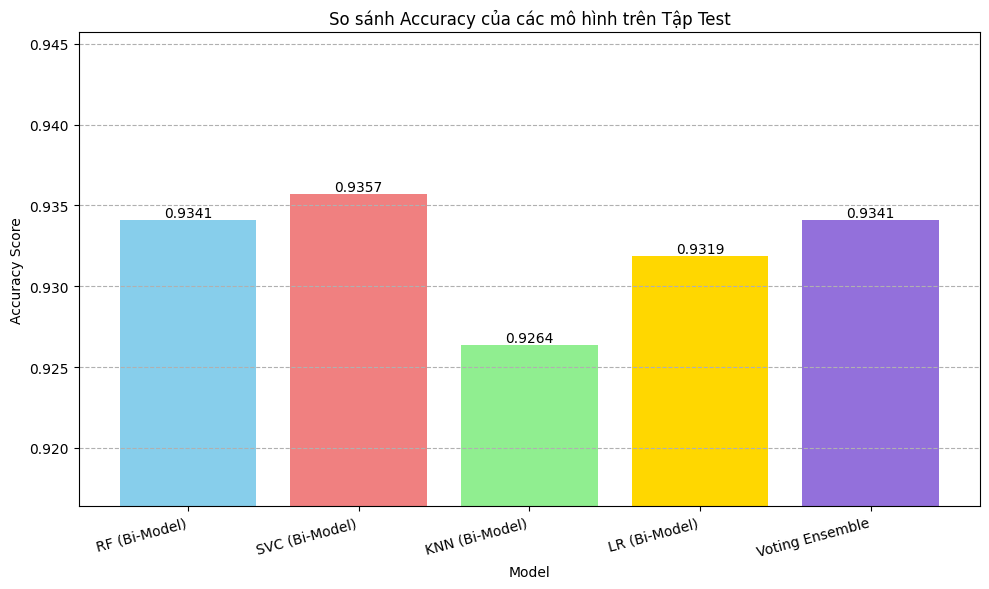

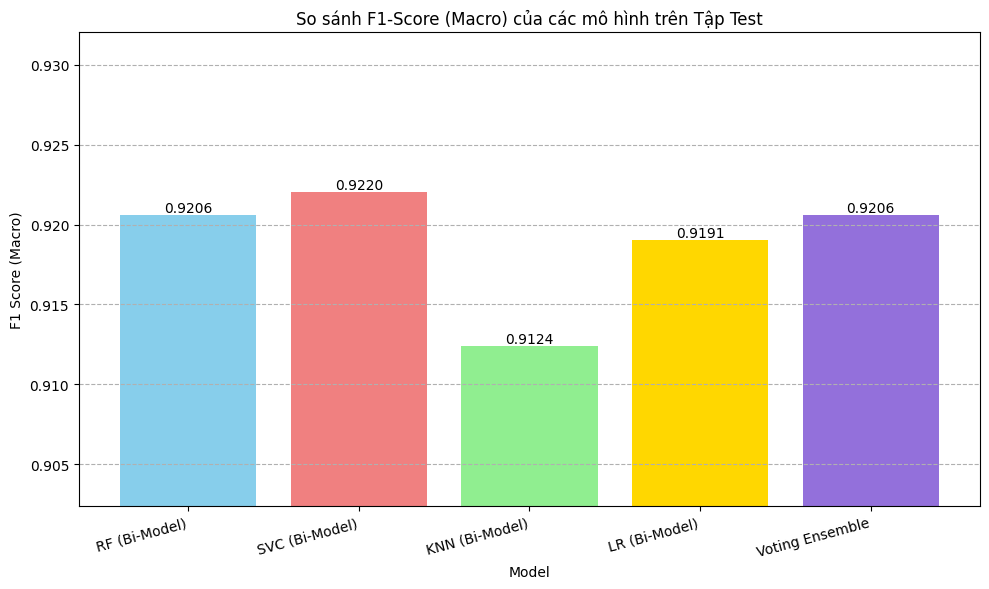

In [34]:
# %% [code]
# --- Tổng hợp và So sánh kết quả trên Tập Test ---
print("\n--- So sánh hiệu năng các mô hình trên Tập Test ---")

# 1. Thu thập kết quả (Đảm bảo các biến accuracy_*, f1_* đã được tính ở các cell trước)
model_names = ['RF (Bi-Model)', 'SVC (Bi-Model)', 'KNN (Bi-Model)', 'LR (Bi-Model)', 'Voting Ensemble']
accuracies = [accuracy_rf, accuracy_svm, accuracy_knn, accuracy_lr, accuracy_ensemble]
f1_scores = [f1_rf, f1_svm, f1_knn, f1_lr, f1_ensemble]
precisions = [precision_rf, precision_svm, precision_knn, precision_lr, precision_ensemble] # Thêm nếu muốn
recalls = [recall_rf, recall_svm, recall_knn, recall_lr, recall_ensemble] # Thêm nếu muốn

# 2. Tạo DataFrame để hiển thị bảng
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'F1 Score (Macro)': f1_scores,
    'Precision (Macro)': precisions,
    'Recall (Macro)': recalls
})

# Định dạng số cho dễ đọc
results_df['Accuracy'] = results_df['Accuracy'].map('{:.4f}'.format)
results_df['F1 Score (Macro)'] = results_df['F1 Score (Macro)'].map('{:.4f}'.format)
results_df['Precision (Macro)'] = results_df['Precision (Macro)'].map('{:.4f}'.format)
results_df['Recall (Macro)'] = results_df['Recall (Macro)'].map('{:.4f}'.format)

print("Bảng tổng hợp kết quả trên tập test:")
print(results_df.to_string(index=False))

# 3. Vẽ biểu đồ cột so sánh Accuracy
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'mediumpurple'])
plt.ylabel("Accuracy Score")
plt.xlabel("Model")
plt.title("So sánh Accuracy của các mô hình trên Tập Test")
plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.01) # Điều chỉnh giới hạn trục y cho rõ ràng
plt.xticks(rotation=15, ha='right') # Hơi xoay tên mô hình nếu dài

# Thêm giá trị accuracy trên mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') # Hiển thị giá trị

plt.grid(axis='y', linestyle='--')
plt.tight_layout() # Tự động điều chỉnh layout
plt.show()

# 4. Vẽ biểu đồ cột so sánh F1-score (Tương tự)
plt.figure(figsize=(10, 6))
bars_f1 = plt.bar(model_names, f1_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'mediumpurple'])
plt.ylabel("F1 Score (Macro)")
plt.xlabel("Model")
plt.title("So sánh F1-Score (Macro) của các mô hình trên Tập Test")
plt.ylim(min(f1_scores) - 0.01, max(f1_scores) + 0.01)
plt.xticks(rotation=15, ha='right')

for bar in bars_f1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()